In [12]:
!git clone https://github.com/davda54/sam

fatal: destination path 'sam' already exists and is not an empty directory.


In [13]:
import sys; sys.path.append("..")

sys.path.append("sam")
from sam import SAM

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from utils import *

device = "cuda" if torch.cuda.is_available() else "cpu"

In [41]:
np.random.seed(seed=1372022)
torch.random.manual_seed(1572022)
N=999
base = 2
digits = base*(math.floor(np.log(N)/np.log(base))+1)

all_primes = list(primes_upto(N+1))
all_primes = [tuple((i, 1)) for i in range(1,N+1) if i in all_primes]
np.random.shuffle(all_primes)
train_primes = all_primes[: math.floor(len(all_primes)*0.8)]
test_primes = set(all_primes[math.floor(len(all_primes)*0.8):])
all_comp = [tuple((i, 0)) for i in range(1,N+1) if i not in train_primes]
np.random.shuffle(all_comp)
train_comp = all_comp[: math.floor(len(all_comp)*0.8)]
test_comp = set(all_comp[math.floor(len(all_comp)*0.8):])

train_data = []
for k in range(N//len(train_primes)):
    train_data += train_primes
train_data += train_comp

test_data = []
for k in range(N//len(test_primes)):
    test_data += test_primes
test_data += test_comp

np.random.shuffle(train_data)
np.random.shuffle(test_data)



In [34]:
count = 0
for i in train_data:
    if i in train_primes:
        count += 1
print(count)
print(len(train_primes))
print(len(train_data))

938
134
1737


In [21]:
#model
input = base*digits
output1 = 64
output2 = 128
#output3 = 64


class MLP(nn.Module):
    
    def __init__(self,output1,output2, output3):
        super().__init__()
        self.step1 = nn.Linear(input, output1)
        self.step2 = nn.Linear(output1, output2)
        self.step3 = nn.Linear(output2, 1)

    def forward(self, x):
        
        x = self.step1(x)
        x = F.relu(x)
        x = self.step2(x)
        x = F.relu(x)
        #x = self.step3(x)
        #x = F.relu(x)
        x = self.step3(x)

        return x

In [93]:
def train_MLP(batch_size=32, epochs=10, tracking=False, div_tracking=False):
  from torchvision import datasets, transforms
  from tqdm.notebook import tqdm, trange

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
  val_loader = torch.utils.data.DataLoader(test_data, shuffle=False)

  ## Training
  # Instantiate model  
  model = MLP(output1, output2, output3).to(device) 

  # Loss and Optimizer
  base_optimizer = torch.optim.SGD
  optimizer = SAM(model.parameters(), base_optimizer,rho=0.05, lr = 0.01, momentum=0.9, weight_decay=0.0005)
  # optimizer = SAM(model.parameters(), base_optimizer, lr = 0.01)
  criterion = nn.BCEWithLogitsLoss()

  training_losses = []
  training_accuracies = []
  validation_accuracies = []

  output_list = []

  # Iterate through train set minibatchs 
  for epoch in trange(epochs):  
      per_epoch_loss = 0
      correct = 0
      for numbers, labels in train_loader:
          x = numbers[:,None]
          x = x.to(device)
          x = encode(x, digits, base).float()
          labels = labels.double().to(device)[:,None]
          # Zero out the gradients
          optimizer.zero_grad()

          def closure():
            loss = criterion(model(x), labels)
            loss.backward()
            return loss

          # Forward pass
          y = model(x)
          loss = criterion(y, labels)
          if tracking:
            # Tracking loss
            per_epoch_loss += loss

            # Train accuracy tracking
            predictions = ((y>0)*1)
            correct += torch.sum((predictions == labels).float())

            # Validation accuracy tracking


          loss.backward()
          optimizer.step(closure)
      if tracking:
        correct_test = 0
        with torch.no_grad():
                # Iterate through test set minibatchs 
                for numbers2, labels2 in val_loader:
                    numbers2 = numbers2.to(device)
                    labels2 = labels2.double().to(device)[:,None]
                    # Forward pass
                    x2 = numbers2[:,None]
                    x2 = encode(x2, digits, base).float()
                    y2 = model(x2)
                    predictions2 = ((y2>0)*1)[:,0]
                    correct_test += torch.sum((predictions2 == labels2).float())

        training_losses.append(per_epoch_loss/len(train_loader))
        training_accuracies.append(correct/len(train_data))
        validation_accuracies.append(correct_test/len(test_data))
      if div_tracking:
        with torch.no_grad():
                x3 = torch.arange(1, N+1)[:, None]
                x3 = encode(x3, digits, base).float()
                model_outputs = model(x3)
                output_list.append(model_outputs.detach().numpy())

  training_losses = [i.item() for i in training_losses]
  training_accuracies = [i.item() for i in training_accuracies]
  validation_accuracies = [i.item() for i in validation_accuracies]

  return model, training_losses, training_accuracies, validation_accuracies, np.array(output_list)


In [106]:
model, training_losses, training_accuracies, validation_accuracies, output_list = train_MLP(batch_size=32, epochs=2000, tracking=True, div_tracking=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

c:\Users\szilv\OneDrive\Dokumentumok\summer_2022\Summer-2022\utils.py:61: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  batch=torch.nn.functional.one_hot(torch.remainder(batch//t[None, :].to(torch.int64), base), num_classes=base)


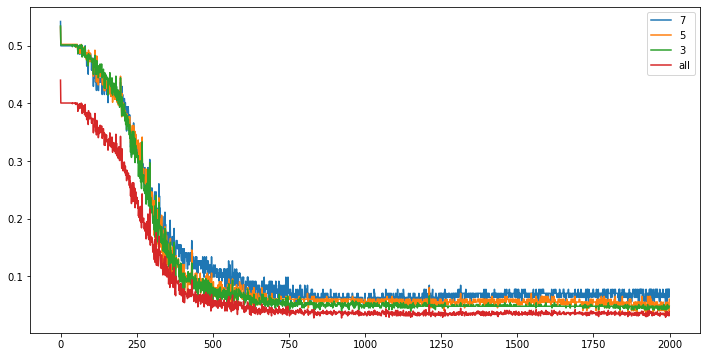

In [109]:
plt.figure(figsize=(12, 6))
non_primes = output_list[:,[x-1 for x in range(1, N+1) if x not in primes_upto(N+1)],0]
false_positives = (non_primes > 0).mean(1)
def false_positive_counter(prime):
    output = output_list[:, prime-1 ::prime, 0]
    false_positives = (output > 0).mean(1)
    return false_positives

plt.plot(false_positive_counter(7), label="7")
plt.plot(false_positive_counter(5), label="5")
plt.plot(false_positive_counter(3), label="3")
plt.plot(false_positives, label="all")
plt.legend(loc="upper right")
plt.show()

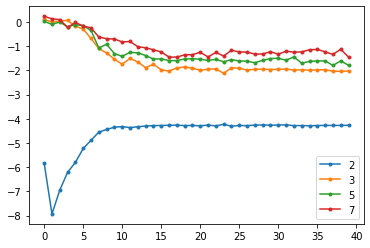

In [110]:
X = np.zeros((N, 4))
X[1::2, 0] = 1
X[2::3, 1] = 1
X[4::5, 2] = 1
X[6::7, 3] = 1
coeffs=[]

from sklearn.linear_model import LogisticRegression
for e in range(0, 2000, 50):
    explainer = LogisticRegression(penalty='l2')
    explainer.fit(X, output_list[e, :, 0]>0)
    coeffs.append(explainer.coef_)
plt.plot(np.array(coeffs)[:,0,:], '.-')
plt.legend(["2", "3", "5", "7"])

In [10]:
# ## Testing
# correct = 0
# total = len(test_data)

# with torch.no_grad():
#     # Iterate through test set minibatchs 
#     for numbers, labels in tqdm(test_loader):
#         numbers = numbers.to(device)
#         labels = labels.to(device)
#         # Forward pass
#         x = numbers[:,None]
#         x = encode(x, digits, base).float()
#         y = model(x)
#         predictions = ((y>0)*1)[:, 0]
#         correct += torch.sum((predictions == labels).float())

# print('Test accuracy: {}'.format(correct/total))

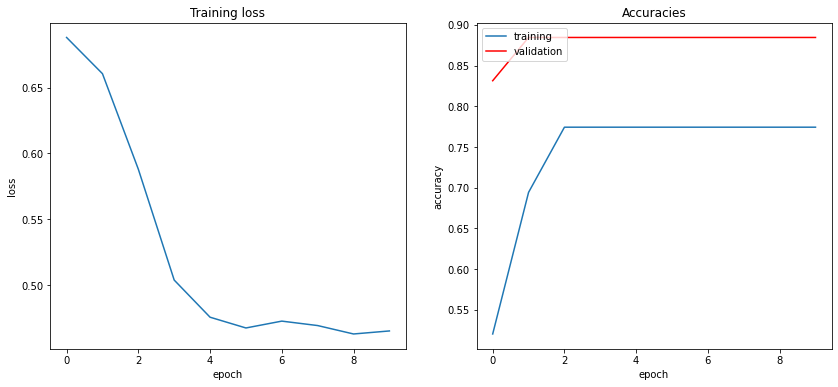

In [81]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(training_losses)
plt.title('Training loss')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='training')
plt.plot(validation_accuracies, color = 'red', label='validation')
plt.title('Accuracies')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()


In [42]:
_, _, _, _, div_list = train_MLP(batch_size=32, epochs=400, tracking=False, div_tracking=True, divisor=1)

  0%|          | 0/400 [00:00<?, ?it/s]

c:\Users\szilv\OneDrive\Dokumentumok\summer_2022\Summer-2022\utils.py:61: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  batch=torch.nn.functional.one_hot(torch.remainder(batch//t[None, :].to(torch.int64), base), num_classes=base)


In [ ]:
comp_acc = [i for index, i in enumerate(div_list) if index+1 not in all_primes]
acc_7 = div_list[6::7]


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

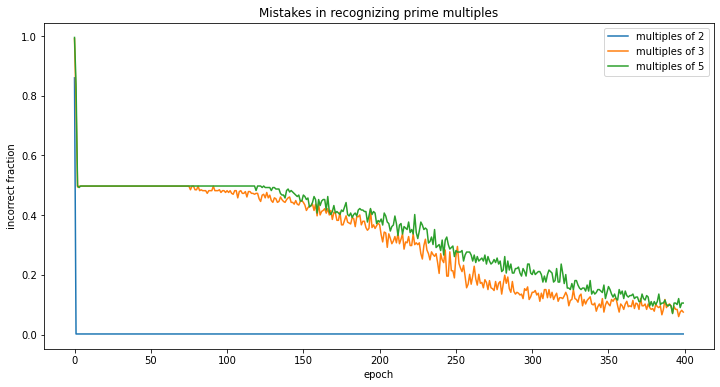

In [37]:
plt.figure(figsize=(12, 6))
plt.title('Mistakes in recognizing prime multiples')
plt.xlabel("epoch")
plt.ylabel("incorrect fraction")
for prime in primes_upto(6):
    _, _, _, _, div_list = train_MLP(batch_size=32, epochs=400, tracking=False, div_tracking=True, divisor=prime)
    plt.plot(div_list, label=f"multiples of {prime}")
plt.legend(loc="upper right")
plt.show()

  0%|          | 0/400 [00:00<?, ?it/s]

c:\Users\szilv\OneDrive\Dokumentumok\summer_2022\Summer-2022\utils.py:61: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  batch=torch.nn.functional.one_hot(torch.remainder(batch//t[None, :].to(torch.int64), base), num_classes=base)


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

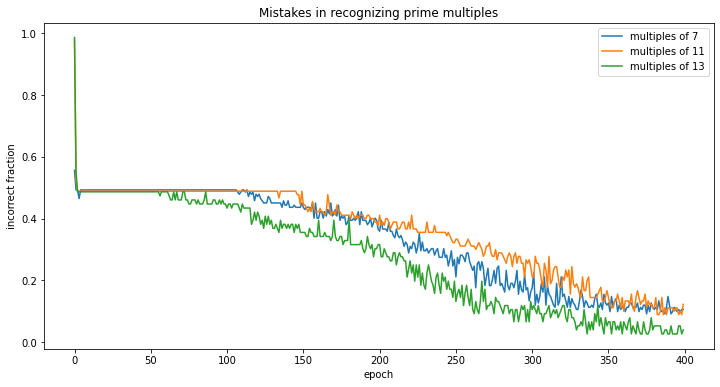

In [36]:
plt.figure(figsize=(12, 6))
plt.title('Mistakes in recognizing prime multiples')
plt.xlabel("epoch")
plt.ylabel("incorrect fraction")
for prime in [7, 11, 13]:
    _, _, _, _, div_list = train_MLP(batch_size=32, epochs=400, tracking=False, div_tracking=True, divisor=prime)
    plt.plot(div_list, label=f"multiples of {prime}")
plt.legend(loc="upper right")
plt.show()

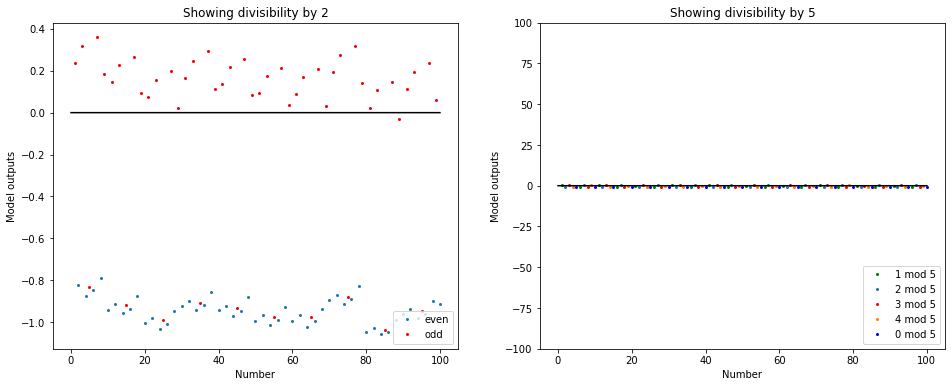

In [13]:
preds = [float(model(encode(torch.tensor([[i]]), digits, base).float())) for i in range(1,N+1)]

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, N+1)[1:100:2], preds[1:100:2], 'o', markersize = 2, label="even")
plt.plot(range(1, N+1)[0:100:2], preds[0:100:2], 'ro', markersize = 2, label="odd")
#plt.ylim([-100, 100])
plt.plot(np.linspace(0, 100, 10000), np.zeros(10000), color='black')
plt.xlabel('Number')
plt.ylabel('Model outputs')
plt.title('Showing divisibility by 2')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
# plt.plot(range(1, N+1)[1:100:3], preds[1:100:3], 'ro', markersize = 2, label="0 mod 3")
plt.plot(range(1, N+1)[0:100:5], preds[0:100:5], 'go', markersize = 2, label="1 mod 5")
plt.plot(range(1, N+1)[1:100:5], preds[1:100:5], 'o', markersize = 2, label="2 mod 5")
plt.plot(range(1, N+1)[2:100:5], preds[2:100:5], 'ro', markersize = 2, label="3 mod 5")
plt.plot(range(1, N+1)[3:100:5], preds[3:100:5], 'o', markersize = 2, label="4 mod 5")
plt.plot(range(1, N+1)[4:100:5], preds[4:100:5], 'bo', markersize = 2, label="0 mod 5")
plt.ylim([-100, 100])
plt.plot(np.linspace(0, 100, 10000), np.zeros(10000), color='black')
plt.xlabel('Number')
plt.ylabel('Model outputs')
plt.title('Showing divisibility by 5')
plt.legend(loc='lower right')
plt.show()



In [14]:
print([index+1 for index, i in enumerate(preds) if i<0 if index%2==0][:20])
print([[index+1]+primeFactors(index+1) for index, i in enumerate(preds) if i > 0 if not isPrime(index+1)])
print([index+1 for index, i in enumerate(preds) if i < 0 if isPrime(index+1)])

[5, 15, 25, 35, 45, 55, 65, 75, 85, 89, 95, 105, 115, 125, 129, 135, 145, 155, 159, 165]
[[1], [9, 3, 3], [21, 3, 7.0], [27, 3, 3, 3], [33, 3, 11.0], [39, 3, 13.0], [49, 7, 7], [51, 3, 17.0], [57, 3, 19.0], [63, 3, 3, 7], [69, 3, 23.0], [77, 7, 11.0], [81, 3, 3, 3, 3], [87, 3, 29.0], [91, 7, 13.0], [93, 3, 31.0], [99, 3, 3, 11.0], [111, 3, 37.0], [117, 3, 3, 13.0], [119, 7, 17.0], [121, 11, 11], [123, 3, 41.0], [133, 7, 19.0], [141, 3, 47.0], [143, 11, 13.0], [147, 3, 7, 7], [153, 3, 3, 17.0], [161, 7, 23.0], [171, 3, 3, 19.0], [177, 3, 59.0], [183, 3, 61.0], [187, 11, 17.0], [201, 3, 67.0], [203, 7, 29.0], [207, 3, 3, 23.0], [209, 11, 19.0], [213, 3, 71.0], [217, 7, 31.0], [231, 3, 7, 11], [237, 3, 79.0], [243, 3, 3, 3, 3, 3], [247, 13, 19.0], [253, 11, 23.0], [267, 3, 89.0], [273, 3, 7, 13], [297, 3, 3, 3, 11], [301, 7, 43.0], [303, 3, 101.0], [309, 3, 103.0], [323, 17, 19.0], [327, 3, 109.0], [333, 3, 3, 37.0], [341, 11, 31.0], [343, 7, 7, 7], [357, 3, 7, 17], [363, 3, 11, 11], [371

In [18]:
x = torch.tensor([[77]])

x = encode(x, digits, base).float()
model(x)

/Users/zsiga007/Summer_2022/Summer-2022/utils.py:61: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  batch=torch.nn.functional.one_hot(torch.remainder(batch//t[None, :].to(torch.int64), base), num_classes=base)


tensor([[0.3199]], grad_fn=<AddmmBackward0>)